---
layout: post
title: Custom Datasets & Dataloaders in PyTorch
date: 2023-09-06
category: AI
tags: deep-learning, RAM, python, neural-networks, colab, pytorch
---

[Google Colab](https://colab.google/) is one of my favorite tools (as a matter of fact, this post was written there). It is a platform that hosts Jupyter Notebooks for free and even provides access to GPUs. As a result of the limited compute and the memory constraints, Colab is ideally suited for prototyping, not training complex, production-grade models on enormous datasets.

At the time of this writing, the free GPU instance gives users 12.7 GB of CPU Random Access Memory (RAM), 15.0 GB of GPU RAM, and 78.2 GB of hard disk drive (HDD) storage. RAM is a type of computer memory that provides fast, temporary storage for data that is actively being used by the computer. It allows for quick access and retrieval of information, making it essential for running programs and tasks in real-time. HDD, on the other hand, is a long-term storage device that uses spinning disks to store data magnetically. It offers high-capacity storage for files and programs but is significantly slower than RAM, making it better suited for storing large amounts of data that doesn't need to be accessed rapidly during active use.

In my experience, I have run into RAM issues in Colab even in small, toy examples. It is routine to have > 12.7 GB of tensors for model training, especially when the tensors have high-dimensionality, such as in image or video tasks. This means that clever approaches are often needed to train models using tensors, as the models need to hold data in RAM to perform calculations.

Enter [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#) (called [DataGenerators](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) in Keras), which allow us to leverage the ample HDD space. As most models do not need access to the entire dataset at a given time (they instead use batches), Data Loaders allow us to only load the data for the current training computations into RAM. We find what we need from disk, load it into RAM, perform some calculations, send it back from disk, and move onto the next batch.

The way to achieve this in PyTorch is via a custom `Dataset` class, which must implement three methods: `__init__`, `__len__`, and `__getitem__`. Simply put, `__init__` is used to instantiate the Dataset object, `__len__` returns the number of samples in the dataset, and `__getitem__` function extracts and returns a sample from the dataset. `__getitem__` is the most important method, as this is where the loading from disk is implemented. To illustrate this process, consider the following example using the [Labeled Faces in the Wild (LFW) dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people), which contains celebrity faces.


*Note that all of this of course applies to any computing environment, Colab is just a great example of where it is particularly helpful.*

In [2]:
from sklearn.datasets import fetch_lfw_people
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import random

Path('/content/data').mkdir(parents=True, exist_ok=True)
path = Path('/content/data')

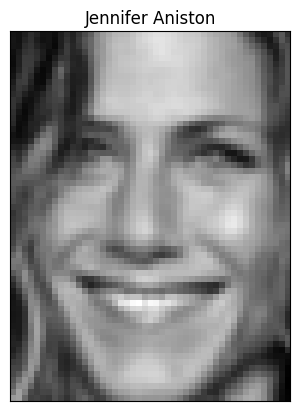

In [3]:
# fetch data and plot a sample face
data = fetch_lfw_people()
plt.xticks(())
plt.yticks(())
plt.title(data['target_names'][data['target'][6400]])
plt.imshow(data['images'][6400], cmap=plt.cm.gray);

In [4]:
# dictionary mapping image ID to label
labels = {}
for idx, image in enumerate(data['images']):
  image_id = f'image_{idx}'
  labels[image_id] = data['target'][idx]
  # images saved to disk using same ID as in label lookup
  torch.save(torch.from_numpy(image), Path.joinpath(path, f'{image_id}.pt'))


files = list(sorted(path.glob('*.pt')))
print(f'Saved {len(files)} samples in {path}')

Saved 13233 samples in /content/data


In [5]:
# partition data into train/val
train_pct = 0.8
num_train = int(len(labels) * train_pct)
ids = list(labels.keys())

random.shuffle(ids)

train_ids = ids[:num_train]
val_ids = ids[num_train:]


partitions = {'train': train_ids,
              'val': val_ids}

In [6]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, data_dir: Path|str, list_IDs: list, labels: dict):
    '''
    data_dir: directory where individual samples are stored
    list_ids: list of all IDs in the data
    labels: dictionary that maps ID to label
    '''
    self.data_dir = data_dir
    self.IDs = list_IDs
    self.labels = labels

  def __len__(self):
    return len(self.IDs)

  def __getitem__(self, index):
    ID = self.IDs[index]
    X = torch.load(Path.joinpath(self.data_dir, f'{ID}.pt'))
    y = self.labels[ID]
    return X, y

In [7]:
params = {'batch_size': 64,
          'shuffle': True}

# dataloader for training
train_set = Dataset(path, partitions['train'], labels)
train_dataloader = torch.utils.data.DataLoader(train_set, **params)

# dataloader for validation
val_set = Dataset(path, partitions['val'], labels)
val_dataloader = torch.utils.data.DataLoader(val_set, **params)

In [8]:
# training loop
n_epochs = 5
samples_seen = 0
for epoch in range(n_epochs):
  for inputs, labels in train_dataloader:
    samples_seen += len(inputs)
    # training code

  for inputs, labels in val_dataloader:
    # validation code
    pass

# confirm that each training sample is seen n_epochs times
assert(samples_seen == len(train_ids)*n_epochs)
print(samples_seen)

52930
